In [7]:
!nvidia-smi

Wed Mar 13 18:00:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8              N/A / ERR! |      6MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
import torch
import torch.nn as nn

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [9]:
torch.cuda.is_available()

True

In [14]:
torch.get_num_threads()

4

In [10]:
# download mnist 
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

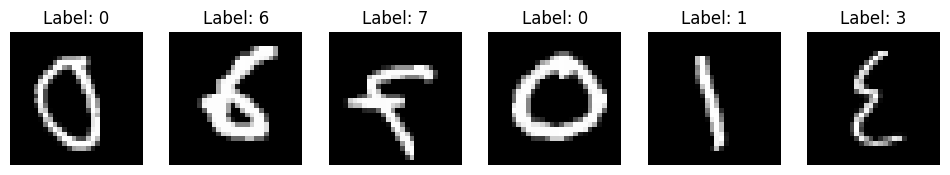

In [11]:
import matplotlib.pyplot as plt

import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = labels[i].item()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [12]:
# define model
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [13]:
# train model

import torch.optim as optim
from sklearn.metrics import precision_score, f1_score

epochs = 10
print_every_n_batches = 50

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# metrics to calcuate
accuracies = []
losses = []
f1s = []


for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0
        running_precision = 0.0
        running_f1 = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            pred_labels = outputs.argmax(dim=1).cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()

            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()
            
            running_precision += precision_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))
            running_f1 += f1_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                precisions.append(running_precision / print_every_n_batches)
                f1s.append(running_f1 / print_every_n_batches)

                running_accuracy = running_loss = running_precision = running_f1 = 0.0

[1,    50] loss: 1.719, accuracy: 0.464
[1,   100] loss: 0.729, accuracy: 0.764
[1,   150] loss: 0.562, accuracy: 0.815
[1,   200] loss: 0.471, accuracy: 0.846
[1,   250] loss: 0.393, accuracy: 0.869
[1,   300] loss: 0.346, accuracy: 0.886
[1,   350] loss: 0.339, accuracy: 0.891
[1,   400] loss: 0.277, accuracy: 0.915
[1,   450] loss: 0.238, accuracy: 0.923
[2,    50] loss: 0.233, accuracy: 0.926
[2,   100] loss: 0.216, accuracy: 0.933
[2,   150] loss: 0.193, accuracy: 0.941
[2,   200] loss: 0.212, accuracy: 0.932
[2,   250] loss: 0.184, accuracy: 0.940
[2,   300] loss: 0.181, accuracy: 0.940
[2,   350] loss: 0.169, accuracy: 0.947
[2,   400] loss: 0.163, accuracy: 0.945
[2,   450] loss: 0.167, accuracy: 0.947
[3,    50] loss: 0.152, accuracy: 0.953
[3,   100] loss: 0.140, accuracy: 0.957
[3,   150] loss: 0.149, accuracy: 0.952
[3,   200] loss: 0.142, accuracy: 0.956
[3,   250] loss: 0.144, accuracy: 0.956
[3,   300] loss: 0.132, accuracy: 0.959
[3,   350] loss: 0.132, accuracy: 0.960
